In [1]:
import pandas as pd
import random
import time
import math
import matplotlib.pyplot as plt

random.seed(int(time.time()))

In [2]:
FILE_QUERIES = '../data/queries_combined/3.csv'

In [3]:
def create_bursty(queries, num_applications, length, offset, delay, burst_interval, burst_intensity, burst_variety, duration_avg, duration_variety, rand_seed = 0):
    
    timeline = pd.DataFrame(columns=['app', 'start', 'query', 'range', 'end'])
    random.seed(rand_seed)
    
    for app in range(num_applications):
        start = delay + offset * app
    
        # one burst at 0 and then as many as still fit with the right starting interval
        num_bursts = (length - start) // burst_interval + 1

        timeline_app = pd.DataFrame(columns=['start', 'query', 'range', 'end'])

        for burst in range(num_bursts):
            curr_time = start + burst * burst_interval

            random_number = random.uniform(-1, 1)
            deviation = burst_intensity * burst_variety * random_number
            num_queries = burst_intensity + int(round(deviation))

            duration_min = duration_avg - (duration_avg * duration_variety)
            duration_max = duration_avg + (duration_avg * duration_variety)
            
            # filter the available queries for the appropriate durations and then select random ones from that
            queries_subset = queries[(queries['duration'] >= (duration_min * 1000)) & (queries['duration'] <= (duration_max * 1000))]

            # possibly needs some seed here as well
            random_rows = queries_subset.sample(n=num_queries, replace=True, random_state = rand_seed + (app + 1) * (burst + 1))
            
            timeline_burst = random_rows[['query', 'range', 'duration']].copy()
            timeline_burst.rename(columns={'duration': 'end'}, inplace=True)
            timeline_burst['end'] = timeline_burst['end'] / 1000
            timeline_burst['end'] = timeline_burst['end'] + curr_time
            timeline_burst['start'] = curr_time

            timeline_app = pd.concat([timeline_app, timeline_burst], ignore_index=True)
            
        timeline_app['app'] = app
        timeline = pd.concat([timeline, timeline_app])

    return timeline

In [4]:
def get_load_changes(timeline):
    start_times = [(time, +1) for time in timeline['start']]
    end_times = [(int(math.ceil(time)), -1) for time in timeline['end']]

    return sorted(start_times + end_times)

def get_load_timeline(load_changes):
    load = 0
    load_timeline = []
    if len(load_changes) > 0:
        last_time = 0
        for time, delta in load_changes:
            if (time != last_time):
                load_timeline.append((last_time, load))
                if (time - last_time > 1):
                    load_timeline.append((time - 1, load))
                last_time = time
            load += delta
        load_timeline.append((last_time, load))
    print(load_timeline)
    return load_timeline


def plot_timeline(timeline: pd.DataFrame):

    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel(f'Time in Seconds')
    ax.set_ylabel('Active Queries')

    for app in timeline['app'].unique():

        load_timeline = get_load_timeline(get_load_changes(timeline[timeline['app'] == app]))
        df_load = pd.DataFrame(load_timeline, columns=['time', 'activeQueries'])
        df_load = df_load.set_index(pd.to_datetime(df_load['time'], unit='s'))

        ax.plot(df_load['time'], df_load['activeQueries'], label=f'App {app}')
    
    ax.legend()
    return

In [ ]:
def save_timeline(timeline, name, location):
    # save the timeline in some format easily usable by spark
    return

In [5]:
queries = pd.read_csv(FILE_QUERIES)

In [6]:
display(queries)

,query,range,duration
0,q1,d_date = cast('2000-04-30' as date),5809
1,q1,d_year = 1999 and d_moy = 8,5906
2,q1,d_date between cast('2000-08-23' as date) and ...,6240
3,q1,d_year = 2000 and d_moy = 1,7800
4,q1,d_year = 2000 and (d_moy between 6 and 8),9272
...,...,...,...
86,q95,d_year = 2000 and d_moy = 1,461744
87,q95,d_year = 2000 and d_moy between 1 and 3,463983
88,q95,d_moy = 11,464519
89,q95,d_year = 2000 and d_moy between 1 and 9,465980


In [9]:
test = create_bursty(
    queries, 
    num_applications=3, 
    length=100,
    offset=15,
    delay=1,
    burst_interval=45,
    burst_intensity=5,
    burst_variety=.3,
    duration_avg=10,
    duration_variety=.6,
    rand_seed=100
    )

In [10]:
display(test)

,app,start,query,range,end
0,0,1,q7,d_year = 2000 and d_moy between 1 and 3,7.463
1,0,1,q12,d_year = 1999 and d_moy = 8,5.777
2,0,1,q12,d_year = 2000 and d_moy between 1 and 9,10.772
3,0,1,q10,d_date = cast('2000-04-30' as date),10.644
4,0,46,q1,d_date = cast('2000-04-30' as date),51.809
5,0,46,q12,d_year = 2000 and d_moy between 1 and 3,51.922
6,0,46,q1,d_date between cast('2000-08-23' as date) and ...,52.240
7,0,46,q12,d_date between cast('2000-08-23' as date) and ...,50.068
8,0,46,q10,d_year = 2000 and d_moy = 1,58.339
9,0,91,q10,d_date between cast('2000-08-23' as date) and ...,101.991


[(0, 0), (1, 4), (5, 4), (6, 3), (7, 3), (8, 2), (10, 2), (11, 0), (45, 0), (46, 5), (50, 5), (51, 4), (52, 2), (53, 1), (58, 1), (59, 0), (90, 0), (91, 6), (95, 6), (96, 4), (97, 4), (98, 3), (100, 3), (101, 1), (102, 0)]
[(0, 0), (15, 0), (16, 6), (20, 6), (21, 5), (22, 3), (23, 2), (28, 2), (29, 0), (60, 0), (61, 6), (66, 6), (67, 4), (70, 4), (71, 3), (72, 3), (73, 2), (74, 1), (75, 0)]
[(0, 0), (30, 0), (31, 5), (35, 5), (36, 3), (37, 3), (38, 2), (40, 2), (41, 1), (42, 0), (75, 0), (76, 6), (80, 6), (81, 3), (82, 2), (87, 2), (88, 0)]


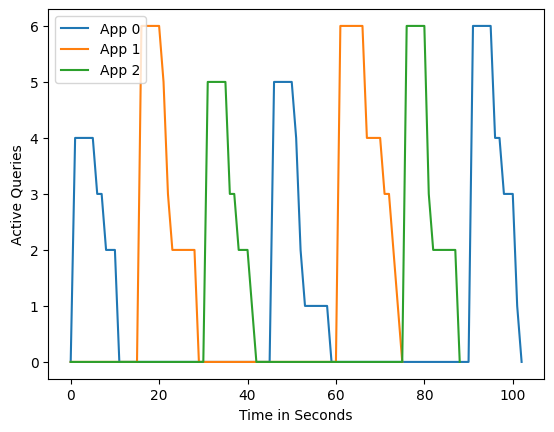

In [11]:
# display(test)
plot_timeline(test)